# Capital One Fraud Detection Case
This is a case to play around with categorical data and detect fraudulent credit card transactions.\
In Session 1, EDA will be performed to learn about the meanings of columns and data. Then I'll do some imputations.\
In Session 2, in order to prepare for modeling, categorial data and numeric data will be identified and account level aggregation will be atempted.\
In Session 3, I'll build a CatBoost model to train the data and predict the probability of a fraudulent transaction. Confusion matrix will be used to evaluate the model performance. 


In [1]:
# data manipulation
import pandas as pd
import numpy as np
import scipy as sp

# syntax encoding
import json

# modeling
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from imblearn.under_sampling import RandomUnderSampler # imbalance-learn is a Python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# computation
import joblib  # a tool to provide lightweight pipelining in Python. 1. easy simple parallel computing, 2. transparent disk-caching of functions and lazy re-evaluation
import tqdm   # a fast, extensible progress bar for loops and CLI
import copy   # shallow and deep copy operations

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Aesthetics
sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 12
pd.options.display.max_columns = 25
pd.options.display.max_rows = 100

# Models
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE


In [2]:
data = pd.read_json("transactions.txt", lines=True)

In [3]:
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,...,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,...,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,...,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,...,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,...,3143,PURCHASE,,0.0,,,,True,,,False,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

# 1 Exploratory Development Analysis

#### 1.1 Fraudulant value percentage - class imbalance

In [5]:
data.isFraud.value_counts() / data.shape[0]

isFraud
False    0.98421
True     0.01579
Name: count, dtype: float64

In [6]:
data['isFraud'].isnull().sum()

0

In [7]:
# convert the datetime columns to datetime objects
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
data['accountOpenDate'] = pd.to_datetime(data['accountOpenDate'])
data['dateOfLastAddressChange'] = pd.to_datetime(data['dateOfLastAddressChange'])
data.head(2)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,...,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,...,767,PURCHASE,,0.0,,,,True,,,False,False


#### 1.2 Explore POS Entry Mode and POS Cond Code, pay attention to 80/90/91

In [8]:
POS_entrymode = data['posEntryMode'].value_counts()
POS_entrymode

posEntryMode
05    315035
09    236481
02    195934
90     19576
80     15283
        4054
Name: count, dtype: int64

In [9]:
# Filter the DataFrame for rows where isFraud is True
fraud = data[data['isFraud'] == True]
fraud_counts_ent = fraud.groupby('posEntryMode').size()
fraud_counts_ent


posEntryMode
       269
02    3421
05    2456
09    5659
80     240
90     372
dtype: int64

In [10]:
fraud_counts_cond = fraud.groupby('posConditionCode').size()
fraud_counts_cond


posConditionCode
         22
01    10230
08     1936
99      229
dtype: int64

posConditionCode: It is a code identifying transaction conditions at the point-of-sale. https://www.mreports.com/documentation/ac/nonmerchant/80449.htm

In [11]:
fraud['transactionDate'] = fraud['transactionDateTime'].dt.date
fraud['transactionTime'] = fraud['transactionDateTime'].dt.time

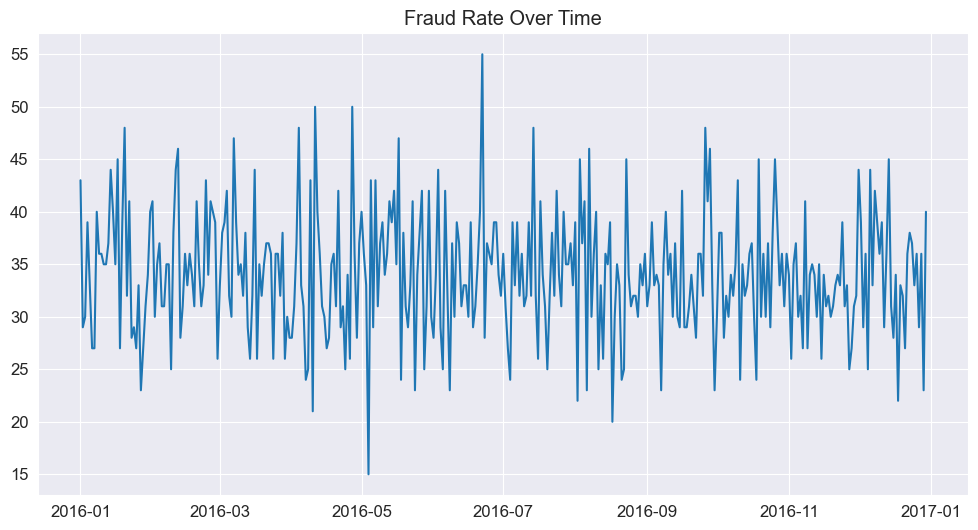

In [12]:
fraud_counts_date = fraud.groupby('transactionDate').size()
fraud_counts_time = fraud.groupby('transactionTime').size()
plt.title('Fraud Rate Over Time')
plt.plot(fraud_counts_date.index, fraud_counts_date.values)
plt.show()

#### 1.3 Address Missing values 
Drop the six all NaN columns ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] 

In [13]:
# drop the six all NaN columns
data.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True)
data.shape

(786363, 23)

In [14]:
# check the missing values in the rest columns
data.replace("", np.nan, inplace=True)
data.isna().sum().sort_values(ascending=False)

acqCountry                  4562
posEntryMode                4054
merchantCountryCode          724
transactionType              698
posConditionCode             409
accountNumber                  0
dateOfLastAddressChange        0
expirationDateKeyInMatch       0
cardPresent                    0
currentBalance                 0
cardLast4Digits                0
enteredCVV                     0
cardCVV                        0
merchantCategoryCode           0
accountOpenDate                0
currentExpDate                 0
customerId                     0
merchantName                   0
transactionAmount              0
transactionDateTime            0
availableMoney                 0
creditLimit                    0
isFraud                        0
dtype: int64

In [15]:
# replace empty strings with np.nan while downcasting the changed columns' data types
pd.set_option('future.no_silent_downcasting', True)
data = data.replace(r'^\s*$', np.nan, regex=True)

In [16]:
def clean_merchant_name(name):
    return name.split('#')[0].strip()

data['merchantName'] = data['merchantName'].apply(clean_merchant_name)

In [17]:
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


In [18]:
# Extract the 'x_hr', 'x_d', 'x_DOW', 'x_mon', 'x_yr', 't_since_open', 't_since_update_add', and 't_2_exp' from the existing columns and drop the original ones
data['x_hr'] = data['transactionDateTime'].dt.hour
data["transactionDate"] = data["transactionDateTime"].dt.date
data['x_d'] = data['transactionDateTime'].dt.day
data['x_DOW'] = data['transactionDateTime'].dt.dayofweek
data['x_mon'] = data['transactionDateTime'].dt.month
data['x_yr'] = data['transactionDateTime'].dt.year
# data['t_since_open'] = (data['transactionDateTime'] - data['accountOpenDate']).dt.days
# data['t_since_update_add'] = (data['transactionDateTime'] - data['dateOfLastAddressChange']).dt.days
# data['t_2_exp'] = (data['currentExpDate'] - data['transactionDateTime']).dt.days


In [19]:
column_names = data.columns.tolist()
column_names

['accountNumber',
 'customerId',
 'creditLimit',
 'availableMoney',
 'transactionDateTime',
 'transactionAmount',
 'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'currentExpDate',
 'accountOpenDate',
 'dateOfLastAddressChange',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType',
 'currentBalance',
 'cardPresent',
 'expirationDateKeyInMatch',
 'isFraud',
 'x_hr',
 'transactionDate',
 'x_d',
 'x_DOW',
 'x_mon',
 'x_yr']

In [20]:
for col in data.columns:
    data[col] = data[col].astype(str)  # Convert all columns to string
    data[col] = data[col].replace('nan', None)

#### 1.4 Duplicate transactions

In [21]:
attrs = ["customerId", "accountOpenDate", "dateOfLastAddressChange",
         "merchantName", "acqCountry", "merchantCountryCode", "merchantCategoryCode",
         "currentExpDate", "cardCVV", "enteredCVV", "cardLast4Digits", "cardPresent", "expirationDateKeyInMatch",
         "posEntryMode", "posConditionCode",
         "transactionAmount"]
df_duplicates = data[data.duplicated(subset=attrs, keep=False)]
df_duplicates = df_duplicates.sort_values(attrs+ ["transactionDateTime"])
df_duplicates

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,x_hr,transactionDate,x_d,x_DOW,x_mon,x_yr
541963,100088067,100088067,50000,49834.2,2016-11-20 07:57:05,22.32,AMC,US,US,09,01,entertainment,...,4615,PURCHASE,165.8,True,False,False,7,2016-11-20,20,6,11,2016
541964,100088067,100088067,50000,49811.88,2016-11-20 08:00:04,22.32,AMC,US,US,09,01,entertainment,...,4615,REVERSAL,188.12,True,False,False,8,2016-11-20,20,6,11,2016
541919,100088067,100088067,50000,50000.0,2016-05-05 22:47:50,3.96,Apple iTunes,US,US,09,01,mobileapps,...,4615,PURCHASE,0.0,False,False,False,22,2016-05-05,5,3,5,2016
541926,100088067,100088067,50000,49695.85,2016-06-05 22:10:41,3.96,Apple iTunes,US,US,09,01,mobileapps,...,4615,PURCHASE,304.15,False,False,False,22,2016-06-05,5,6,6,2016
541929,100088067,100088067,50000,50000.0,2016-07-05 22:22:49,3.96,Apple iTunes,US,US,09,01,mobileapps,...,4615,PURCHASE,0.0,False,False,False,22,2016-07-05,5,1,7,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108110,999389635,999389635,5000,4900.94,2016-08-22 11:42:48,4.62,Play Store,US,US,05,01,mobileapps,...,3991,PURCHASE,99.06,False,False,False,11,2016-08-22,22,0,8,2016
108112,999389635,999389635,5000,4653.7,2016-09-22 13:58:30,4.62,Play Store,US,US,05,01,mobileapps,...,3991,PURCHASE,346.3,False,False,False,13,2016-09-22,22,3,9,2016
108113,999389635,999389635,5000,4674.08,2016-10-23 16:47:41,4.62,Play Store,US,US,05,01,mobileapps,...,3991,PURCHASE,325.92,False,False,False,16,2016-10-23,23,6,10,2016
108114,999389635,999389635,5000,4694.46,2016-11-24 00:21:46,4.62,Play Store,US,US,05,01,mobileapps,...,3991,PURCHASE,305.54,False,False,False,0,2016-11-24,24,3,11,2016


In [22]:
df_duplicates["transactionType"].value_counts(dropna=False)


transactionType
PURCHASE                75550
REVERSAL                15999
ADDRESS_VERIFICATION      923
None                       31
Name: count, dtype: int64

In [23]:
data["transactionType"].value_counts(dropna=False)

transactionType
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
None                       698
Name: count, dtype: int64

#### 1.5 Reversal transactions 
Sometimes can be deemed signs of fraudulent transactions. 

In [24]:
df_id_amount_reversal = \
df_duplicates[df_duplicates["transactionType"]=="REVERSAL"][attrs]

df_id_amount_reversal

,customerId,accountOpenDate,dateOfLastAddressChange,merchantName,acqCountry,merchantCountryCode,merchantCategoryCode,currentExpDate,cardCVV,enteredCVV,cardLast4Digits,cardPresent,expirationDateKeyInMatch,posEntryMode,posConditionCode,transactionAmount
541964,100088067,2014-01-09,2014-01-09,AMC,US,US,entertainment,06/2020,546,546,4615,True,False,09,01,22.32
87920,100328049,2014-01-07,2014-01-07,Lyft,US,US,rideshare,05/2027,206,206,2941,False,False,09,08,43.74
87936,100328049,2014-01-07,2014-01-07,McDonalds,US,US,fastfood,10/2027,206,206,2941,True,False,02,08,284.97
151499,100737756,2015-06-21,2015-06-21,34th BBQ,US,US,food,05/2026,463,463,4317,True,False,05,01,93.67
151541,100737756,2015-06-21,2015-06-21,Best Bistro,US,US,food,07/2021,463,463,4317,True,False,05,01,501.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545581,999258704,2015-12-22,2015-12-22,gap.com,US,US,online_retail,05/2025,708,708,3757,False,False,09,01,72.93
670038,999283629,2015-11-08,2016-03-09,Delta Airlines,US,US,airline,08/2021,919,919,4157,False,False,05,01,247.4
670109,999283629,2015-11-08,2016-03-09,Franks Sandwitch Bar,US,US,food,03/2030,489,489,3016,True,False,09,01,150.58
670052,999283629,2015-11-08,2016-03-09,Lyft,US,US,rideshare,06/2029,489,489,3016,False,False,05,08,96.56


In [25]:
reversal_indices = df_id_amount_reversal.index
reversal_indices

Index([541964,  87920,  87936, 151499, 151541, 151595, 474250, 474247,   3080,
         3052,
       ...
       569793, 569751, 545536, 545572, 545555, 545581, 670038, 670109, 670052,
       670091],
      dtype='int64', length=15999)

In [26]:
df_id_amount_reversal[attrs].drop_duplicates().shape

(15999, 16)

In [27]:
df_id_amount_reversal

,customerId,accountOpenDate,dateOfLastAddressChange,merchantName,acqCountry,merchantCountryCode,merchantCategoryCode,currentExpDate,cardCVV,enteredCVV,cardLast4Digits,cardPresent,expirationDateKeyInMatch,posEntryMode,posConditionCode,transactionAmount
541964,100088067,2014-01-09,2014-01-09,AMC,US,US,entertainment,06/2020,546,546,4615,True,False,09,01,22.32
87920,100328049,2014-01-07,2014-01-07,Lyft,US,US,rideshare,05/2027,206,206,2941,False,False,09,08,43.74
87936,100328049,2014-01-07,2014-01-07,McDonalds,US,US,fastfood,10/2027,206,206,2941,True,False,02,08,284.97
151499,100737756,2015-06-21,2015-06-21,34th BBQ,US,US,food,05/2026,463,463,4317,True,False,05,01,93.67
151541,100737756,2015-06-21,2015-06-21,Best Bistro,US,US,food,07/2021,463,463,4317,True,False,05,01,501.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545581,999258704,2015-12-22,2015-12-22,gap.com,US,US,online_retail,05/2025,708,708,3757,False,False,09,01,72.93
670038,999283629,2015-11-08,2016-03-09,Delta Airlines,US,US,airline,08/2021,919,919,4157,False,False,05,01,247.4
670109,999283629,2015-11-08,2016-03-09,Franks Sandwitch Bar,US,US,food,03/2030,489,489,3016,True,False,09,01,150.58
670052,999283629,2015-11-08,2016-03-09,Lyft,US,US,rideshare,06/2029,489,489,3016,False,False,05,08,96.56


In [28]:
df_id_amount_reversal['transactionAmount'] = pd.to_numeric(df_id_amount_reversal['transactionAmount'], errors='coerce')
data['transactionAmount'] = pd.to_numeric(data['transactionAmount'], errors='coerce')
df_duplicates['transactionAmount'] = pd.to_numeric(df_duplicates['transactionAmount'], errors='coerce')

In [29]:
df_id_amount_reversal['transactionAmount'].sum() / data['transactionAmount'].sum()

0.02156091764891927

In [30]:
df_id_amount_reversal2 = pd.merge(df_id_amount_reversal, df_duplicates,how="inner", on=attrs)
df_id_amount_reversal2

,customerId,accountOpenDate,dateOfLastAddressChange,merchantName,acqCountry,merchantCountryCode,merchantCategoryCode,currentExpDate,cardCVV,enteredCVV,cardLast4Digits,cardPresent,...,creditLimit,availableMoney,transactionDateTime,transactionType,currentBalance,isFraud,x_hr,transactionDate,x_d,x_DOW,x_mon,x_yr
0,100088067,2014-01-09,2014-01-09,AMC,US,US,entertainment,06/2020,546,546,4615,True,...,50000,49834.2,2016-11-20 07:57:05,PURCHASE,165.8,False,7,2016-11-20,20,6,11,2016
1,100088067,2014-01-09,2014-01-09,AMC,US,US,entertainment,06/2020,546,546,4615,True,...,50000,49811.88,2016-11-20 08:00:04,REVERSAL,188.12,False,8,2016-11-20,20,6,11,2016
2,100328049,2014-01-07,2014-01-07,Lyft,US,US,rideshare,05/2027,206,206,2941,False,...,5000,4648.84,2016-01-15 20:34:35,PURCHASE,351.16,False,20,2016-01-15,15,4,1,2016
3,100328049,2014-01-07,2014-01-07,Lyft,US,US,rideshare,05/2027,206,206,2941,False,...,5000,4605.1,2016-01-15 20:36:18,REVERSAL,394.9,False,20,2016-01-15,15,4,1,2016
4,100328049,2014-01-07,2014-01-07,McDonalds,US,US,fastfood,10/2027,206,206,2941,True,...,5000,4077.06,2016-03-24 22:57:15,PURCHASE,922.94,False,22,2016-03-24,24,3,3,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32191,999283629,2015-11-08,2016-03-09,Franks Sandwitch Bar,US,US,food,03/2030,489,489,3016,True,...,2500,2034.1,2016-11-19 18:48:08,REVERSAL,465.9,False,18,2016-11-19,19,5,11,2016
32192,999283629,2015-11-08,2016-03-09,Lyft,US,US,rideshare,06/2029,489,489,3016,False,...,2500,2500.0,2016-06-01 23:34:21,PURCHASE,0.0,False,23,2016-06-01,1,2,6,2016
32193,999283629,2015-11-08,2016-03-09,Lyft,US,US,rideshare,06/2029,489,489,3016,False,...,2500,2403.44,2016-06-07 18:32:39,REVERSAL,96.56,False,18,2016-06-07,7,1,6,2016
32194,999283629,2015-11-08,2016-03-09,apple.com,US,US,online_retail,06/2030,489,487,3016,False,...,2500,1775.48,2016-09-15 06:35:31,PURCHASE,724.52,False,6,2016-09-15,15,3,9,2016


#### 1.6 Multi-swipe

In [31]:
df_duplicates.shape

(92503, 29)

# 2 Prepare for modeling
#### 2.1 Separate categorical features vs numerical features.

In [32]:
data["CVVMismatch"] = data["cardCVV"] != data["enteredCVV"]
data["CVVMismatch"].value_counts(dropna=False)

CVVMismatch
False    779348
True       7015
Name: count, dtype: int64

In [33]:
data["countryMismatch"] = data["acqCountry"]!=data["merchantCountryCode"]
data["countryMismatch"].value_counts(dropna=False)

countryMismatch
False    781731
True       4632
Name: count, dtype: int64

In [34]:
data["availableMoney"] = pd.to_numeric(data["availableMoney"])
data["isOverspent"] = data["availableMoney"]<0
data["isOverspent"].value_counts(dropna=False)

isOverspent
False    783432
True       2931
Name: count, dtype: int64

In [35]:
# Ensure the date columns are in datetime format
data['transactionDate'] = pd.to_datetime(data['transactionDate'])
data['dateOfLastAddressChange'] = pd.to_datetime(data['dateOfLastAddressChange'])
data['accountOpenDate'] = pd.to_datetime(data['accountOpenDate'])

data['daysSinceLastAddressChange'] = (data['transactionDate'] - data['dateOfLastAddressChange']).dt.days
data['daysSinceAccountOpen'] = (data['transactionDate'] - data['accountOpenDate']).dt.days

In [36]:
cat_features = ['customerId', 'creditLimit', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 
        'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'cardPresent',
       'expirationDateKeyInMatch']

#### 2.2 Imputation

In [37]:
for f in cat_features:
    # print(data[data[f].astype(str).str.contains("<Unknown>")].shape)
    if data[f].isna().sum()>0:
        print(f)
        data[f].fillna("<Unknown>", inplace=True)

acqCountry


/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_41107/2993669937.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[f].fillna("<Unknown>", inplace=True)


merchantCountryCode
posEntryMode
posConditionCode
transactionType


In [38]:
data.isna().sum()

accountNumber                 0
customerId                    0
creditLimit                   0
availableMoney                0
transactionDateTime           0
transactionAmount             0
merchantName                  0
acqCountry                    0
merchantCountryCode           0
posEntryMode                  0
posConditionCode              0
merchantCategoryCode          0
currentExpDate                0
accountOpenDate               0
dateOfLastAddressChange       0
cardCVV                       0
enteredCVV                    0
cardLast4Digits               0
transactionType               0
currentBalance                0
cardPresent                   0
expirationDateKeyInMatch      0
isFraud                       0
x_hr                          0
transactionDate               0
x_d                           0
x_DOW                         0
x_mon                         0
x_yr                          0
CVVMismatch                   0
countryMismatch               0
isOversp

In [39]:
data

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,isFraud,x_hr,transactionDate,x_d,x_DOW,x_mon,x_yr,CVVMismatch,countryMismatch,isOverspent,daysSinceLastAddressChange,daysSinceAccountOpen
0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,...,False,14,2016-08-13,13,5,8,2016,False,False,False,518,518
1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC,US,US,09,01,entertainment,...,False,5,2016-10-11,11,1,10,2016,False,False,False,577,577
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,...,False,9,2016-11-08,8,1,11,2016,False,False,False,605,605
3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,...,False,2,2016-12-10,10,5,12,2016,False,False,False,637,637
4,830329091,830329091,5000,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons,US,US,02,01,fastfood,...,False,21,2016-03-24,24,3,3,2016,False,False,False,231,231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,2016-12-22 18:44:12,119.92,Lyft,US,US,90,01,rideshare,...,False,18,2016-12-22,22,3,12,2016,False,False,False,1582,1582
786359,732852505,732852505,50000,48785.04,2016-12-25 16:20:34,18.89,hulu.com,US,US,09,01,online_subscriptions,...,False,16,2016-12-25,25,6,12,2016,False,False,False,1585,1585
786360,732852505,732852505,50000,48766.15,2016-12-27 15:46:24,49.43,Lyft,US,US,02,01,rideshare,...,False,15,2016-12-27,27,1,12,2016,False,False,False,1587,1587
786361,732852505,732852505,50000,48716.72,2016-12-29 00:30:55,49.89,walmart.com,US,US,09,99,online_retail,...,False,0,2016-12-29,29,3,12,2016,False,False,False,1589,1589


#### 2.3 Account level aggregates

In [40]:
attrs_to_agg = [["customerId"]]
for f in cat_features:
    if f not in ["customerId", "cardPresent", "expirationDateKeyInMatch"]:
        attrs_to_agg.append(["customerId", f])
print(len(attrs_to_agg))

13


In [41]:
attrs_to_agg

[['customerId'],
 ['customerId', 'creditLimit'],
 ['customerId', 'merchantName'],
 ['customerId', 'acqCountry'],
 ['customerId', 'merchantCountryCode'],
 ['customerId', 'posEntryMode'],
 ['customerId', 'posConditionCode'],
 ['customerId', 'merchantCategoryCode'],
 ['customerId', 'currentExpDate'],
 ['customerId', 'cardCVV'],
 ['customerId', 'enteredCVV'],
 ['customerId', 'cardLast4Digits'],
 ['customerId', 'transactionType']]

In [42]:
print(data[['transactionDateTime', 'transactionAmount']].dtypes)
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])


transactionDateTime     object
transactionAmount      float64
dtype: object


In [43]:
cols_agg_acct = []
for attr in attrs_to_agg:
    print(attr)
    data.sort_values(attr + ["transactionDateTime"], inplace=True)
    data[f"recency_by_{'_'.join(attr)}"] = data.groupby(attr)["transactionDateTime"].diff().dt.seconds
    
    first_seen = data.groupby(attr)["transactionDateTime"].first()
    first_seen_dict = first_seen.to_dict()
    if len(attr)==1:
        data[f"age_by_{'_'.join(attr)}"] = data.apply(lambda r:r["transactionDateTime"] - first_seen[r[attr[0]]], axis=1).dt.seconds
    elif len(attr)==2:
        data[f"age_by_{'_'.join(attr)}"] = data.apply(lambda r:r["transactionDateTime"] - first_seen_dict[(r[attr[0]],r[attr[1]])], axis=1).dt.seconds
    else:
        raise NotImplementedError
    
    data[f"count_by_{'_'.join(attr)}"] = data.groupby(attr).cumcount()

    data[f"sum_by_{'_'.join(attr)}"] = data.groupby(attr)["transactionAmount"].cumsum() - data["transactionAmount"]

    data[f"avg_by_{'_'.join(attr)}"] = data[f"sum_by_{'_'.join(attr)}"] / data[f"count_by_{'_'.join(attr)}"]

    cols_agg_acct.extend([f"recency_by_{'_'.join(attr)}",
                         f"age_by_{'_'.join(attr)}",
                         f"count_by_{'_'.join(attr)}",
                         f"sum_by_{'_'.join(attr)}",
                         f"avg_by_{'_'.join(attr)}"])

['customerId']
['customerId', 'creditLimit']
['customerId', 'merchantName']
['customerId', 'acqCountry']
['customerId', 'merchantCountryCode']
['customerId', 'posEntryMode']
['customerId', 'posConditionCode']
['customerId', 'merchantCategoryCode']
['customerId', 'currentExpDate']
['customerId', 'cardCVV']
['customerId', 'enteredCVV']
['customerId', 'cardLast4Digits']
['customerId', 'transactionType']


In [44]:
cols_agg_acct

['recency_by_customerId',
 'age_by_customerId',
 'count_by_customerId',
 'sum_by_customerId',
 'avg_by_customerId',
 'recency_by_customerId_creditLimit',
 'age_by_customerId_creditLimit',
 'count_by_customerId_creditLimit',
 'sum_by_customerId_creditLimit',
 'avg_by_customerId_creditLimit',
 'recency_by_customerId_merchantName',
 'age_by_customerId_merchantName',
 'count_by_customerId_merchantName',
 'sum_by_customerId_merchantName',
 'avg_by_customerId_merchantName',
 'recency_by_customerId_acqCountry',
 'age_by_customerId_acqCountry',
 'count_by_customerId_acqCountry',
 'sum_by_customerId_acqCountry',
 'avg_by_customerId_acqCountry',
 'recency_by_customerId_merchantCountryCode',
 'age_by_customerId_merchantCountryCode',
 'count_by_customerId_merchantCountryCode',
 'sum_by_customerId_merchantCountryCode',
 'avg_by_customerId_merchantCountryCode',
 'recency_by_customerId_posEntryMode',
 'age_by_customerId_posEntryMode',
 'count_by_customerId_posEntryMode',
 'sum_by_customerId_posEntryM

In [45]:
# joblib.dump(cols_agg_acct, "cols_agg_acct.jobblib")
joblib.dump(cols_agg_acct, "cols_agg_acct_v2.jobblib")

['cols_agg_acct_v2.jobblib']

In [46]:
data.to_csv("data_after_aggregates_v2.csv", index=False)

In [47]:
data.shape

(786363, 99)

In [48]:
cat_features

['customerId',
 'creditLimit',
 'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'currentExpDate',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType',
 'cardPresent',
 'expirationDateKeyInMatch']

In [49]:
features_basic = ['customerId', 'creditLimit', 'availableMoney', 
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 
        'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch',
       'daysSinceLastAddressChange', 'daysSinceAccountOpen', 
        'countryMismatch', 'CVVMismatch', 'isOverspent']

In [50]:
joblib.dump(features_basic, "features_basic.joblib")

['features_basic.joblib']

In [52]:
features = features_basic + cols_agg_acct
len(features)

88

## 3 CatBoost Model

In [53]:
y = data['isFraud']
X = data[features]
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class_weights = [1, y_train1.value_counts()[0] / y_train1.value_counts()[1]]
print(class_weights)

X_train, X_eval, y_train, y_eval = train_test_split(X_train1, y_train1, test_size=0.1, random_state=42)

/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_41107/4177320317.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights = [1, y_train1.value_counts()[0] / y_train1.value_counts()[1]]
/var/folders/b9/3zhww04j2174xmq7j9y05kf80000gn/T/ipykernel_41107/4177320317.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights = [1, y_train1.value_counts()[0] / y_train1.value_counts()[1]]


[1, 62.32695792228709]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6631610	test: 0.6608632	best: 0.6608632 (0)	total: 743ms	remaining: 12m 21s
100:	learn: 0.4217269	test: 0.4046853	best: 0.4046853 (100)	total: 40.3s	remaining: 5m 59s
200:	learn: 0.4095519	test: 0.3959415	best: 0.3959415 (200)	total: 1m 24s	remaining: 5m 36s
300:	learn: 0.3990878	test: 0.3926547	best: 0.3925666 (291)	total: 2m 9s	remaining: 5m 1s
400:	learn: 0.3840881	test: 0.3917959	best: 0.3913444 (393)	total: 2m 57s	remaining: 4m 24s
500:	learn: 0.3712108	test: 0.3914027	best: 0.3912260 (491)	total: 3m 45s	remaining: 3m 44s
600:	learn: 0.3587819	test: 0.3916645	best: 0.3912260 (491)	total: 4m 35s	remaining: 3m 2s
700:	learn: 0.3475190	test: 0.3924279	best: 0.3912260 (491)	total: 5m 26s	remaining: 2m 19s
800:	learn: 0.3368905	test: 0.3939621	best: 0.3912260 (491)	total: 6m 14s	remaining: 1m 33s
900:	learn: 0.3267336	test: 0.3946544	best: 0.3912260 (491)	total: 6m 54s	remaining: 45.5s
999:	learn: 0.3178021	test: 0.3968011	best: 0.3912260 (491)	total: 7m 31s	remaining: 0us


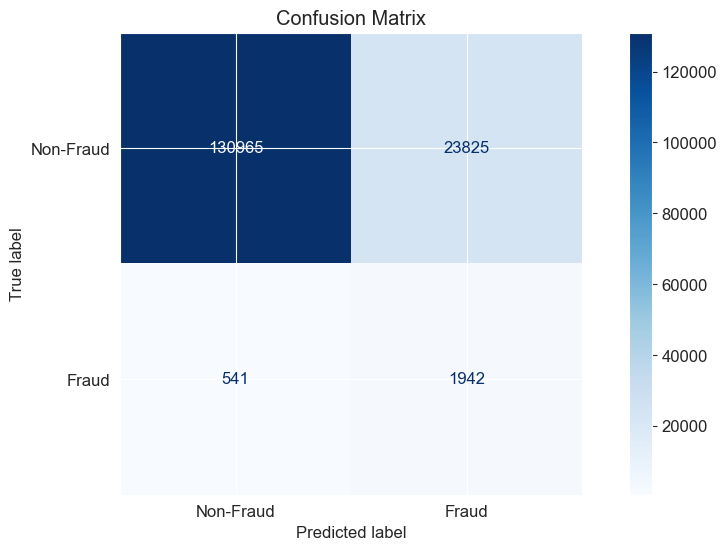

Model Accuracy on Test Set: 84.51%


In [54]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,           
    learning_rate=0.05,        
    depth=6,                   
    cat_features=cat_features,
    class_weights=class_weights,
    verbose=100                # Print the training progress every 100 iterations
)

model.fit(X_train, y_train, eval_set=(X_eval,y_eval), plot=True)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
ROC_AUC = roc_auc_score(y_test, y_pred_proba)
print(f"ROC_AUC: {ROC_AUC:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print(f"Model Accuracy on Test Set: {model.score(X_test, y_test) * 100:.2f}%")

#### Address class imbalance issue

In [55]:
# non_fraud_weight = 1
# fraud_weight = (1 - 0.05) / 0.05 * (0.015 / (1 - 0.015))
# class_weights = {0: 1, 1: 20}
class_weights = [1, 20]

y2 = data['isFraud']
X2 = data[features]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y)

# class_weights = [1, y_train1.value_counts()[0] / y_train1.value_counts()[1]]
# print(class_weights)
X_train, X_eval, y_train, y_eval = train_test_split(X_train2, y_train2, test_size=0.1, random_state=42)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6707545	test: 0.6712718	best: 0.6712718 (0)	total: 420ms	remaining: 6m 59s
100:	learn: 0.3365571	test: 0.3237839	best: 0.3237839 (100)	total: 39.8s	remaining: 5m 54s
200:	learn: 0.3277437	test: 0.3170542	best: 0.3170542 (200)	total: 1m 17s	remaining: 5m 6s
300:	learn: 0.3201966	test: 0.3143348	best: 0.3142157 (296)	total: 1m 58s	remaining: 4m 36s
400:	learn: 0.3113155	test: 0.3132813	best: 0.3131497 (389)	total: 2m 42s	remaining: 4m 3s
500:	learn: 0.3035467	test: 0.3129808	best: 0.3127897 (467)	total: 3m 26s	remaining: 3m 26s
600:	learn: 0.2963540	test: 0.3127658	best: 0.3123806 (555)	total: 4m 15s	remaining: 2m 49s
700:	learn: 0.2894348	test: 0.3126558	best: 0.3122630 (660)	total: 5m 1s	remaining: 2m 8s
800:	learn: 0.2823697	test: 0.3138686	best: 0.3122630 (660)	total: 5m 44s	remaining: 1m 25s
900:	learn: 0.2757928	test: 0.3147539	best: 0.3122630 (660)	total: 6m 27s	remaining: 42.6s
999:	learn: 0.2693840	test: 0.3156179	best: 0.3122630 (660)	total: 7m 10s	remaining: 0us

b

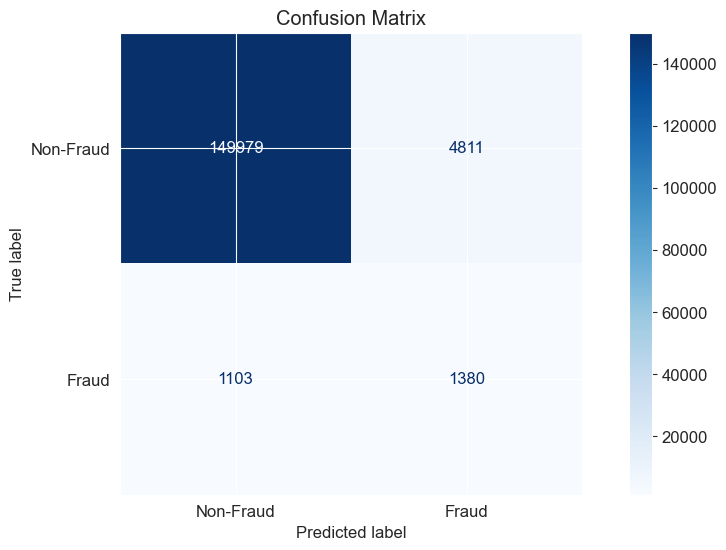

Model Accuracy on Test Set: 96.24%


In [56]:
model = CatBoostClassifier(
    iterations=1000,           
    learning_rate=0.05,        
    depth=6,                   
    cat_features=cat_features,
    class_weights=class_weights,
    verbose=100                # Print the training progress every 100 iterations
)

model.fit(X_train, y_train, eval_set=(X_eval,y_eval), plot=True)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
ROC_AUC = roc_auc_score(y_test, y_pred_proba)
print(f"ROC_AUC: {ROC_AUC:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
print(f"Model Accuracy on Test Set: {model.score(X_test, y_test) * 100:.2f}%")